# Everytime Tha Beat Drop

### Background

Music streaming services like Pandora, Spotify, Tidal, Deezer contain huge libraries of music. This is great for users who search for songs or artists they like, but is difficult for new music discovery and users can be overwhelmed by the options.

As a result, these companies try to build algorithms or recommenders to provide personal recommendations for new music. 

Here, we'll use data from The Echo Nest, a research group that has complied metadata on millions of tracks. We'll further supplement this dataset with further information on track characteristics. We'll try to leverage all of these attributes to build a few classification models to predict whether a track should be classified as genre "hip-hop" or "rock".

<b>Key skills:</b> pandas data manipulation, matplotlib data visualisation, scikit-learn machine learning techniques (e.g. PCA, logistic regression, decision tree, balancing data, k-fold cross-validation)

### 1) Data preparation

In [14]:
import numpy as np
import pandas as pd

In [15]:
# Read track metadata with genre labels
tracks = pd.read_csv("./datasets/fma-rock-vs-hiphop.csv")

In [16]:
# Read track metrics with the features
echonest_metrics = pd.read_json("./datasets/echonest-metrics.json", precise_float = True)

In [17]:
# Merge the two
echo_tracks = echonest_metrics.merge(tracks[['track_id', 'genre_top']], how='inner', on='track_id')

# Have a look at the df
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


### 2) Understand pairwise relationships

* In this project, we want to be mindful of <b>feature redundancy</b>. That is, we don't want to include variables that have strong correlations with each other.
* This can keep the model simplistic and interpretable (using many features can run risk of overfitting).
* This also reduces computation time; if the datasets are very large, they will have long runtime.

So let's build a correlation matrix from the `pandas` package to see if there are any super strongly correlated features around.

In [18]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient() # pandas guy

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


When looking at the above matrix, looks like there aren't any super correlated variables woo. We can continue.

### 3) Principal Component Analysis (PCA) 

* We can use a common technique to reduce the number of features in the dataset to those that are most important: <b>Principal Component Analysis (PCA)</b>. 
* Using PCA as a dimenionality reduction method becomes more important when there are hundreds of features and it won't be efficient to include all in the model; reducing the feature list will improve computation and performance metrics on the model(s).
* Furthermore, it could be possible that the variance between the 2 genres is explained by just a few features.
* PCA rotates the data along the axis of highest variance and so allows us to understand the relative contribution of each feature towards the variance between classes.

#### 3A) Normalise our data

* However, since PCA uses the <b>absolute variance</b> of a feature to rotate the data, one feature with a broad range of values will overpower and thus bias the algorithm, relative to other features. To remove this, we must normalise our data.
* There are a few ways to normalise our data, we'll use the common <b>standardisation </b> method, where all features have a mean=0 and standard deviation = 1 (result is a z-score)

In [19]:
# Define the features 
features = echo_tracks.drop(['genre_top', 'track_id'], axis=1) # axis=1 to drop values from columns

# Define the labels
labels = echo_tracks['genre_top']

In [20]:
from sklearn.preprocessing import StandardScaler 

# Scale the features and set the values to a new variable
scaler = StandardScaler() # defining an instance of the standard scaler
scaled_train_features = scaler.fit_transform(features) # scale the features

#### 3B) Determine number of components

* Now that our data is scaled, we next determine the number of components with which to run PCA. Once this is done, we run PCA using this X number of components and will ideally reduce the dimensionality of our data ay.
* We can leverage <b>scree-plots</b> and <b>cumulative explained variance plots</b> to identify the number of components.
* Scree-plots show the number of components against the variance explained by each component and sorts this in descending order of variance.
* Scree-plots help show which components explain a sufficient amounf of variance in our data.
* Within a scree-plot, we locate the "elbow" (a dramatic drop from one data point to the next) to determine the appropriate cutoff.
* Cumulative explained variance plots can show how many features are required to explain e.g. 85% of the variance (you can assign an arbitrary cutoff for now!)

Scree-plot

[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]
8


Text(0.5, 0, 'Principal Component #')

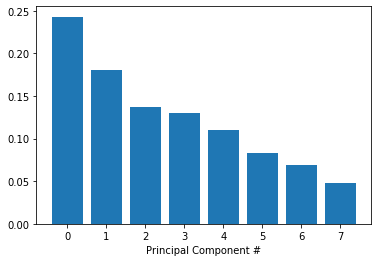

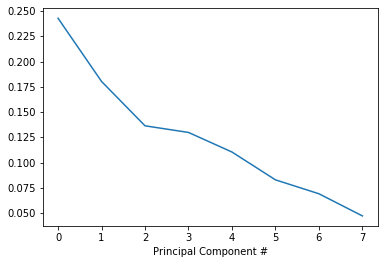

In [21]:
# This is just to make plots appear in the notebook
%matplotlib inline

# Import our plotting module, and PCA class
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get our explained variance ratios from PCA using all features
pca = PCA() # create PCA class; no args means run on all features 
pca.fit(scaled_train_features) # fit model on our train features

exp_variance = pca.explained_variance_ratio_
num_components = pca.n_components_
print(exp_variance)
print(num_components)

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(num_components), exp_variance) # number of components X explained variance
ax.set_xlabel('Principal Component #')

# plot the explained variance using a screeplot
fig, ax = plt.subplots()
ax.plot(range(num_components), exp_variance) # number of components X explained variance
ax.set_xlabel('Principal Component #')

In the above scree-plot, we don't seem to see a clear elbow! So we may need more help to identify the number of intrinsic components. Let's try a cumulative explained variance plot.

Cumulative explained variance plot

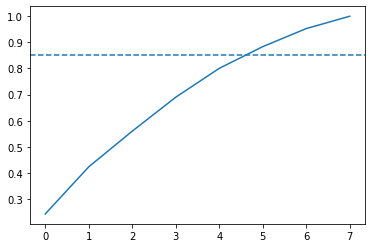

In [22]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance) # cumulative sum

# Plot the cumulative explained variance and draw a dashed line at 0.85.
fig, ax = plt.subplots()
ax.plot(range(num_components), cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

# # choose the n_components where about 85% of our variance can be explained
n_components = 6 # between 4 and 5 but must be an integer

#### 3C) Run PCA

In [24]:
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

We are now ready to try some models! We will model on this new `pca_projection` dataset.

### 4) Train a decision tree to classify the genre

* Moving forward, we'll point to the `pca_projection` dataset.
* We'll first split our data into train and test sets; the train set will be used to train our model, and the test set will be used for performance validation.
* We'll start with a simple <b>decision tree</b> model. Decision trees are rule-based classifiers, and take in features following a tree-like structure. Binary decisions are made to classify a data point into two or more groupings.
* Decision trees are relatively straightforward to use and interpret, and can help us visualise a logical flowchart for the decisioning.

In [25]:
# Import train_test_split function and Decision tree classifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)

In [26]:
# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_features)

### 5) Compare decision tree to a logistic regression model

* Although our decision tree's model performance is alright, it's a good idea to test out some other models to see which is the best fit for our given data.
* <b>Logistic Regression</b> is a simple model; it leverages the logistic function to calculate the probability that a given data point belongs to a given class.
* We can compare both models using some performance metrics.

In [27]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

In [28]:
# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



* Both models seem to perform similarly based on our performance metrics; they have a mean precision of ~87%.
* However, it looks like rock tracks are classified well, but hip-hop tracks are disproportionately misclassified as rock tracks.
* Actually, it looks like there are many more records for the rock classification than the hip-hop classification; this potentially skews our model's ability to discern between the 2 classes. This also means that most of our model's accuracty is driven by its ability to classify rock only. This is not great.

### 6) Balance our data
* To address the problems outlined above, we can weight the value of a correct classification inversely to the occurence of data points for each class. 
* Since a correct "Rock" classification is not more important than a correct "Hip-Hop" classification, we only need to address for differences in sample size of our data points when weighting classes (not relative importance).
* Here we will balance our data, then retry our models and metrics.

In [29]:
# Subset only the hip-hop tracks, and then only the rock tracks
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# sample the rocks songs to be the same number as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# concatenate the dataframes rock_only and hop_only
rock_hop_bal = pd.concat([rock_only,hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))

In [30]:
# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)

### 7) Does balancing our dataset improve model metrics and bias?

* Now that we've balanced our dataset, we've removed many records. 
* However, these may have been crucial to model training. So let's see if balancing out data improves model bias towards "Rock" while retaining overall performance.
* Note: We will move forward without dimensionality reduction on this step. In practice, we would consider applying PCA again, especially when handling very large datasets and computation is important to consider.

In [34]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

In [35]:
# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

In [36]:
# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.73      0.74       230
        Rock       0.73      0.74      0.73       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.80      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



Ayy! Looks like balancing our data removed bias towards th emore prevalent class.

### Apply cross-validation for model evaluation

* To udnerstand how well our models are actually performing, we can apply <b>cross-validation (CV)</b>. This helps us compare models more rigorously.
* CV attempts to split our data multiple ways and test the model on each split.
* There are many CV methods, each with different benefits and drawbacks.
* Here, we will use <b>K-fold cross-validation</b>. In this method, we first split the data into K different, equally-sized subsets. Then it takes each subset, iteratively, and uses it as a test set whilst using the remainder data as train. Finally, we aggegate the results from each "fold" to provide a summary model performance score.

In [37]:
from sklearn.model_selection import KFold, cross_val_score

# Set up our K-fold CV
kf = KFold(n_splits=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)

# Train our models using K-fold CV
tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", tree_score.mean(), "Logistic Regression:", logit_score.mean())

Decision Tree: 0.7489010989010989 Logistic Regression: 0.782967032967033


Thanks!